In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.18/24727/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [102]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [103]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futMHW = xr.open_dataarray(localDir + 'mhws_NOWFutRun.nc')
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')

In [104]:
# Mean state files (stored in Guillaumes directory)
mean_dir = '/g/data1a/e14/gs9353/POST-PROCESS/ECLs/'
# We slice away the troublesome regions. Also fix nav_lon
mean_file = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_mean.nc')
seas_file = xr.open_zarr(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_seasonal_cycle.zarr')
seas_file['nav_lon'] = seas_file['nav_lon'] % 360 
mean_file['nav_lon'] = mean_file['nav_lon'] % 360

In [105]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [106]:
futMHW = futMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

In [107]:
# Defining useful parts of mean_file
mld = mean_file['mld_dt02']

In [108]:
# Loading in EKE file
eke = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_Eddy_Kinetic_Energy.nc')['eke']
eke['nav_lon'] = eke['nav_lon'] % 360
eke_diff = eke.sel(simulation = 'Future') - eke.sel(simulation = 'Present')  

In [158]:
# Loading in mean wind speeds
u = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_U_2D_mean.nc')['uos']
v = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_V_2D_mean.nc')['vos']

## Change in MLD region

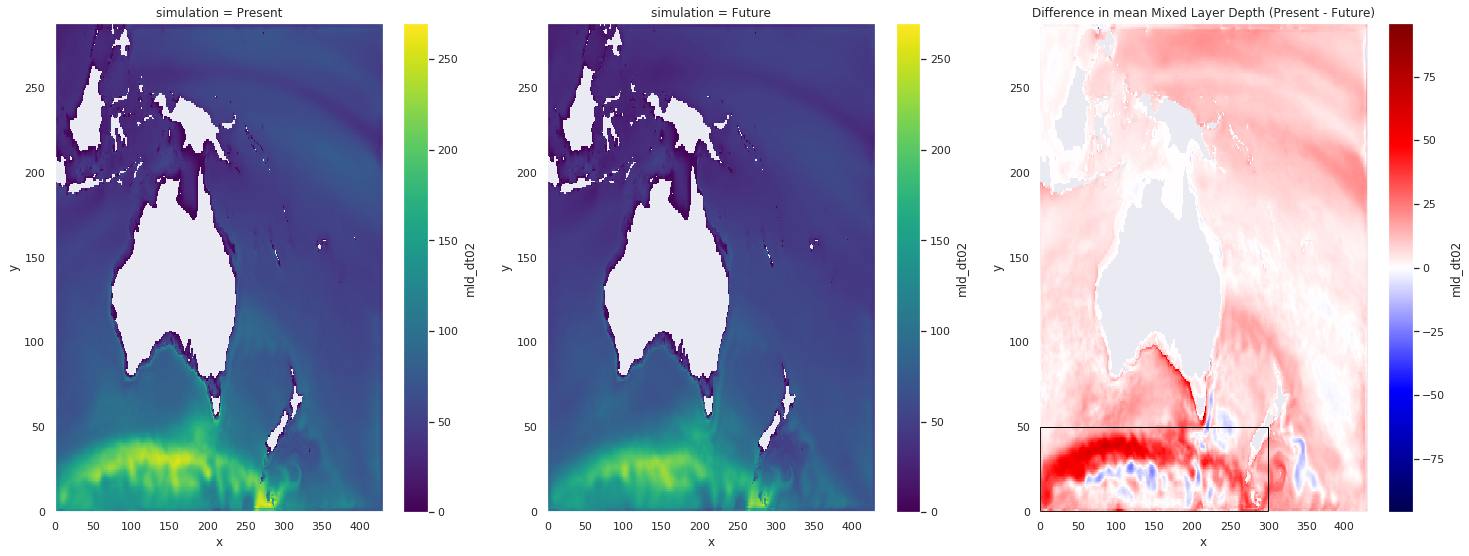

In [232]:
f, axes = plt.subplots(1,3, figsize = [25,9])
(vmin, vmax) = (0, 270)
mld.sel(simulation = 'Present').plot(ax = axes[0], vmin = vmin, vmax = vmax);
mld.sel(simulation = 'Future').plot(ax = axes[1], vmin = vmin, vmax = vmax);
(mld.sel(simulation = 'Present') - mld.sel(simulation = 'Future')).plot(cmap = 'seismic', ax = axes[2]);

axes[2].set_title('Difference in mean Mixed Layer Depth (Present - Future)');

# Plotting rectangle to show region
axes[2].add_patch(Rectangle((0, 0), 300, 50, fill = False, color= 'black'));
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/MLD_diff.png')

In [110]:
diffMHW = futMHW - pastMHW

##### Region of interest is between x = (0, 300) and y = (0, 50)

In [120]:
mld_pReg = mld.sel(simulation = 'Present').isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})
mld_fReg = mld.sel(simulation = 'Future').isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})
mld_diffReg = mld_fReg - mld_pReg

In [121]:
eke_mldReg = eke_diff.isel(y = slice(5,55), x = slice(5, 300))

In [122]:
mldRegp = pastMHW.isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})
mldRegf = futMHW.isel(y = slice(5,55), x = slice(5, 300)).chunk({'x' : 70, 'y' : 60})

In [123]:
mldReg_PSev = mldRegp.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
mldReg_PSev = xr.where(mldReg_PSev == 0, np.nan, mldReg_PSev)

In [124]:
mldReg_FSev = mldRegf.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
mldReg_FSev = xr.where(mldReg_FSev == 0, np.nan, mldReg_FSev)

In [199]:
mldReg_diff_Sev = mldReg_FSev - mldReg_PSev
udiff =  (u.sel(simulation = 'Future') - u.sel(simulation = 'Present')).isel(y = slice(5,55), x = slice(5, 300))
vdiff =  (v.sel(simulation = 'Future') - v.sel(simulation = 'Present')).isel(y = slice(5,55), x = slice(5, 300))

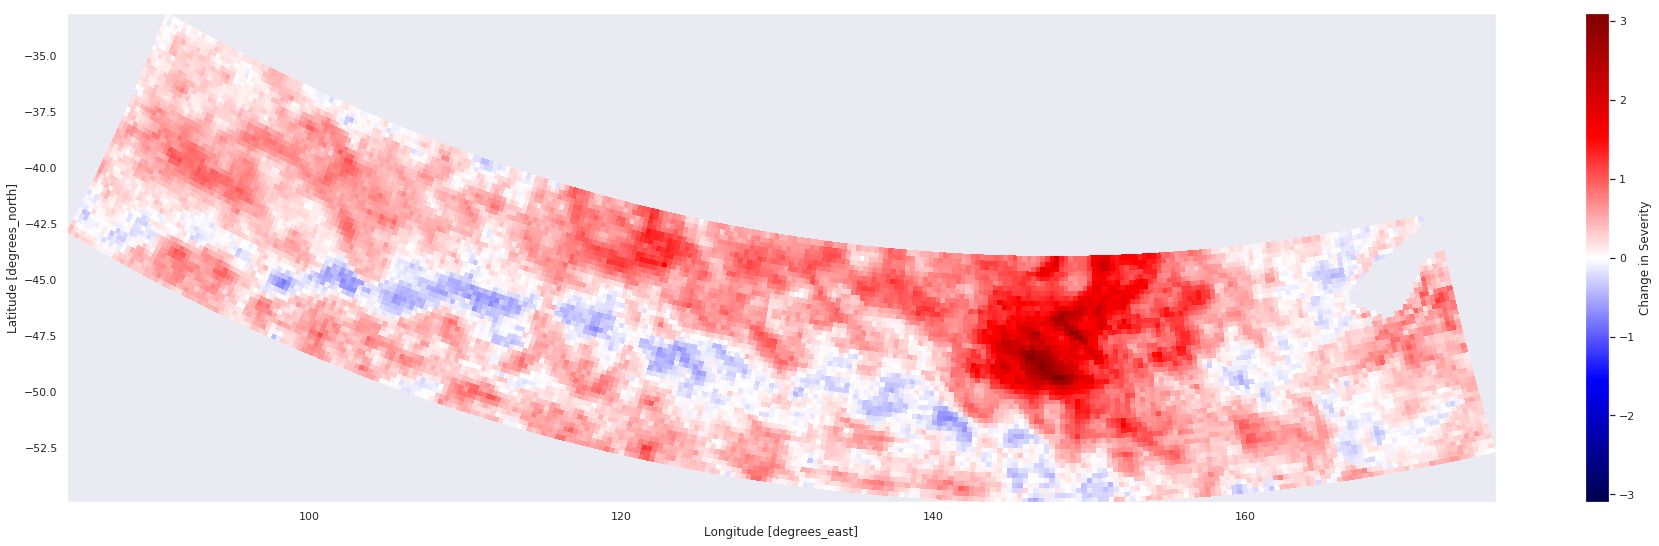

In [233]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9), cbar_kwargs = {'label' : 'Change in Severity'})

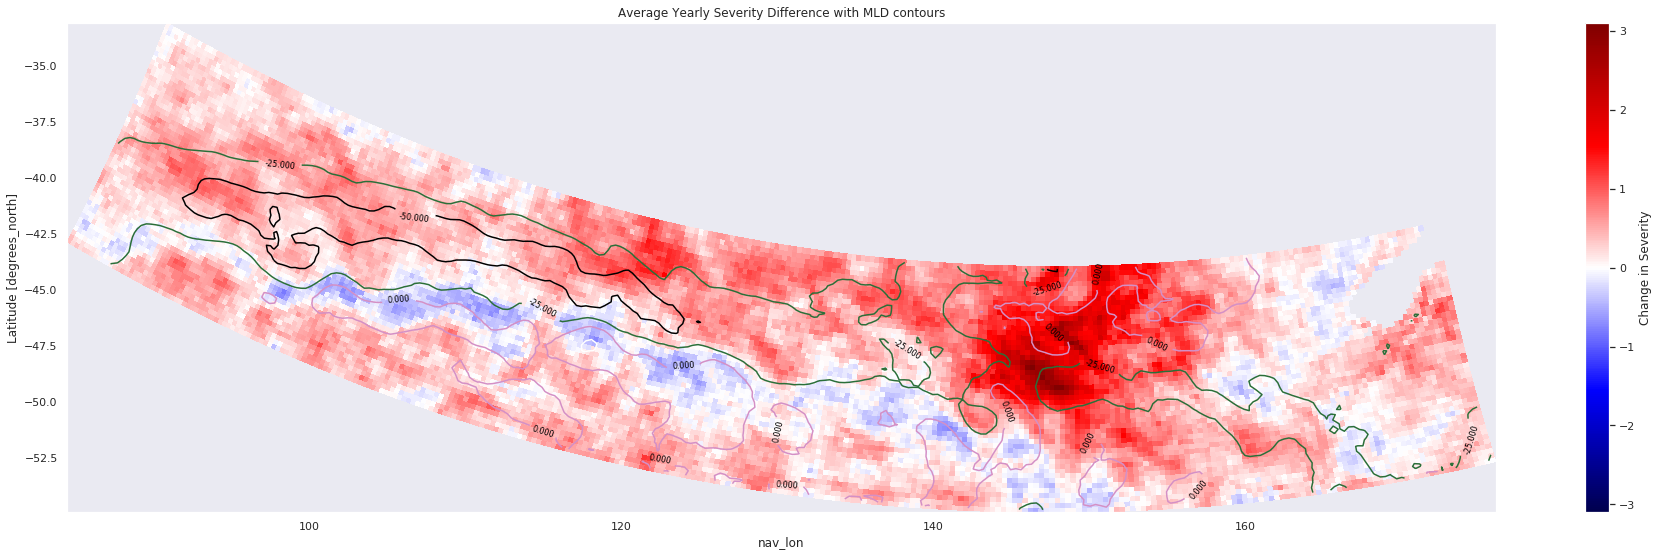

In [208]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9), cbar_kwargs = {'label' : 'Change in Severity'})
a = mld_diffReg.plot.contour(x = 'nav_lon', y = 'nav_lat', cmap = 'cubehelix', levels = [-50, -25, 0, 25]);
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
plt.title("Average Yearly Severity Difference with MLD contours")
plt.savefig('/home/561/rm6294/Documents/Regional Plots/MLD region/maxYearlySev_MLDContour.png')

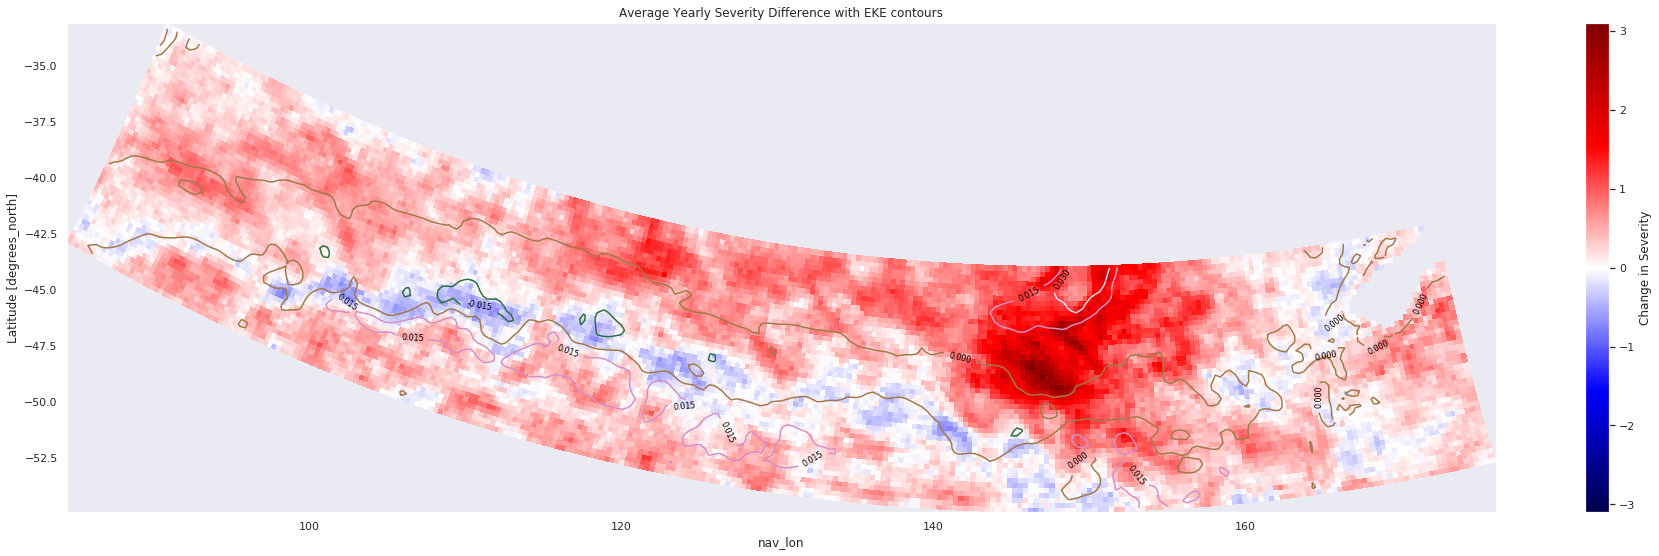

In [209]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9), cbar_kwargs = {'label' : 'Change in Severity'})
a = eke_mldReg.plot.contour(x = 'nav_lon', y = 'nav_lat', cmap = 'cubehelix');
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');
plt.title('Average Yearly Severity Difference with EKE contours')
plt.savefig('/home/561/rm6294/Documents/Regional Plots/MLD region/maxYearlySev_EKEContour.png')

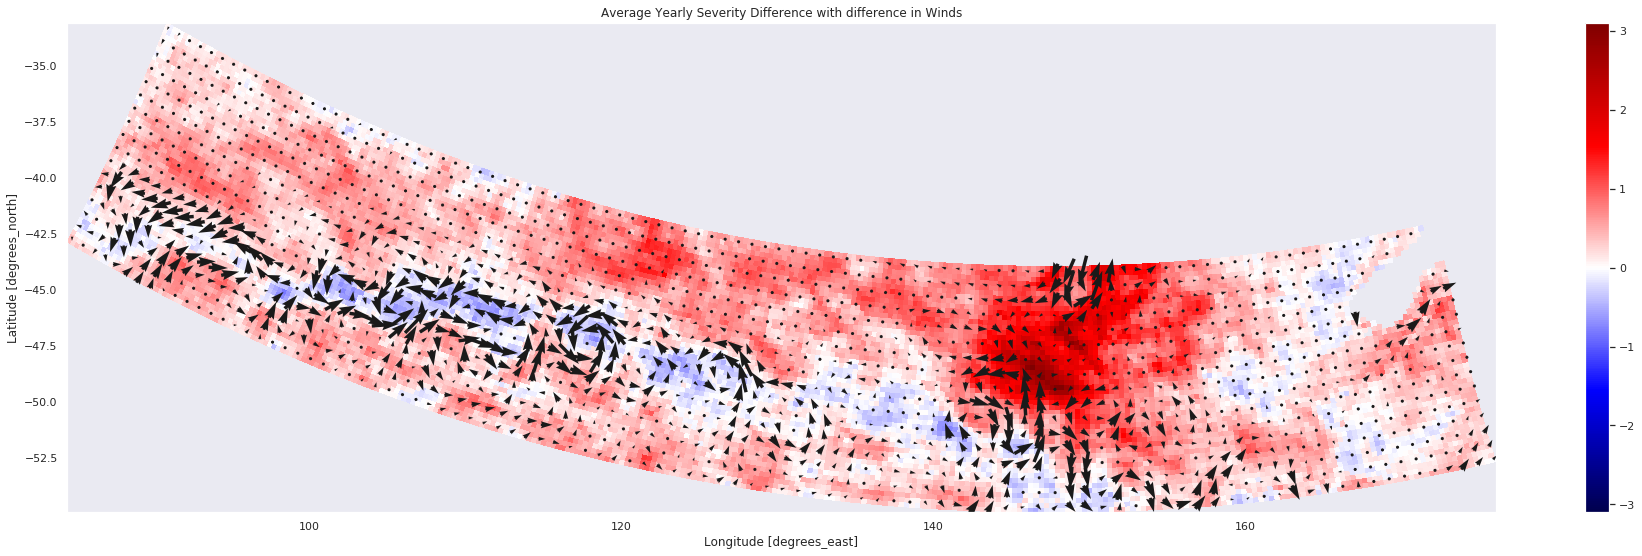

In [210]:
mldReg_diff_Sev.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat', figsize = (32,9))
skip = 3
plt.quiver(udiff['nav_lon'][::skip, ::skip], vdiff['nav_lat'][::skip, ::skip], udiff[::skip, ::skip], vdiff[::skip, ::skip], pivot='middle', angles='xy', scale_units='xy',  scale = 0.1);
plt.title('Average Yearly Severity Difference with difference in Winds')
plt.savefig('/home/561/rm6294/Documents/Regional Plots/MLD region/maxYearlySev_windOverlay.png')

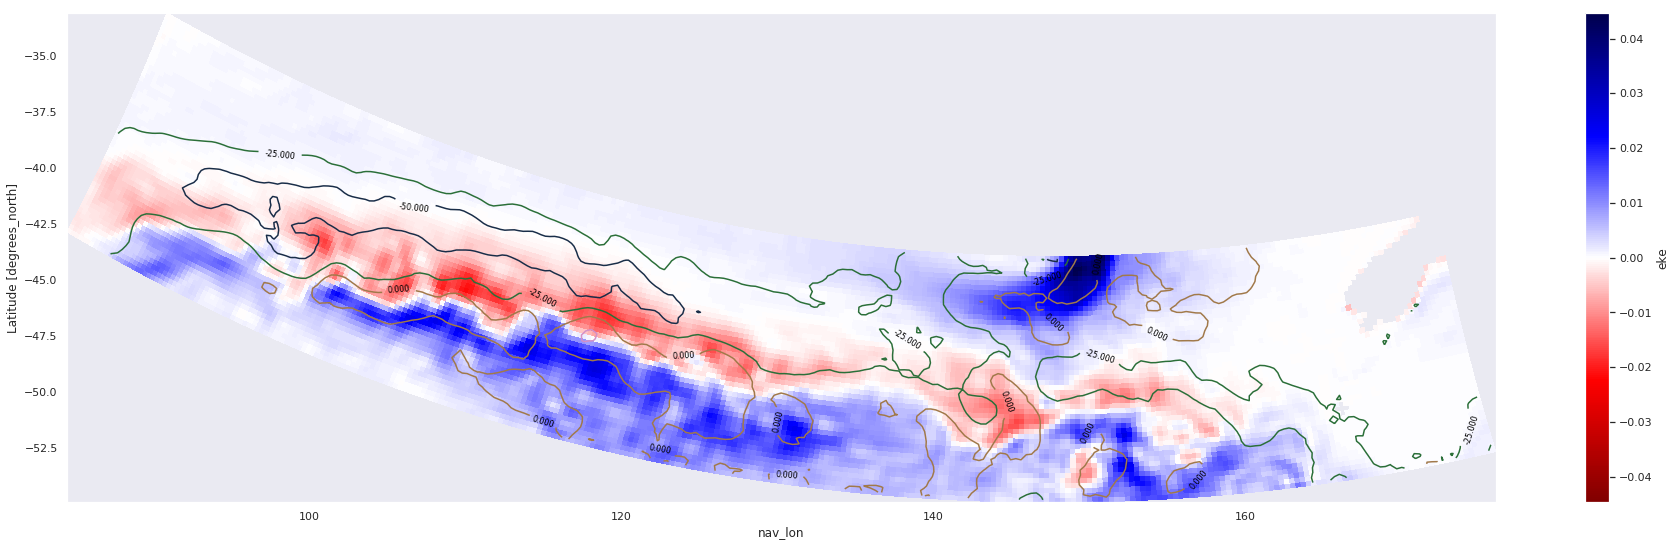

In [152]:
eke_mldReg.plot(cmap = 'seismic_r', x = 'nav_lon', y = 'nav_lat', figsize = (32,9))
a = mld_diffReg.plot.contour(x = 'nav_lon', y = 'nav_lat', cmap = 'cubehelix');
plt.clabel(a, inline = True, fontsize = 8, colors = 'black');

## Tasman Sea 

In [218]:
sev_Ptas_all = pastMHW.isel(y = slice(5,200), x = slice(110, 380))
sev_Ftas_all = futMHW.isel(y = slice(5,200), x = slice(110, 380))

In [219]:
sev_Ptas = sev_Ptas_all.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
sev_Ptas = xr.where(sev_Ptas == 0, np.nan, sev_Ptas)

In [220]:
sev_Ftas = sev_Ftas_all.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()
sev_Ftas = xr.where(sev_Ftas == 0, np.nan, sev_Ftas)

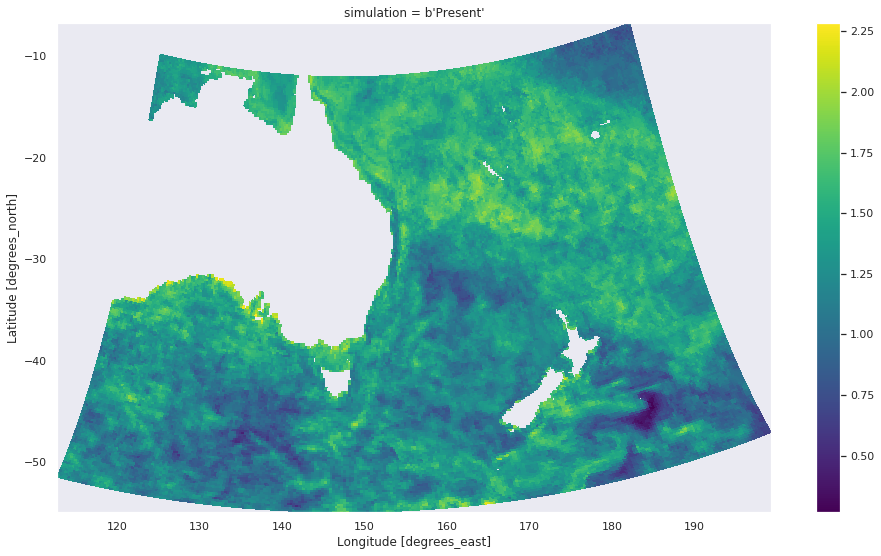

In [231]:
sev_Ptas.plot(x = 'nav_lon', y = 'nav_lat');